In [1]:
import os 
import torch
import gym
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from IPython import display
plt.style.use("ggplot")
from .demo_utils import load_demos

In [2]:
from mini_behavior.envs import *

# ONLY CELL TO CHANGE

In [17]:
task_name = 'SimpleInstallingAPrinter_RSInt'
room_size = 8
env_name = 'MiniGrid-SimpleInstallingAPrinterRSInt-8x8-N2-v0'

print(env_name)

MiniGrid-SimpleInstallingAPrinterRSInt-8x8-N2-v0


In [18]:
ALL_DEMOS_DIR = '/Users/emilyjin/Code/behavior/mini_behavior/demos'
ALL_MODELS_DIR = '/Users/emilyjin/Code/behavior/mini_behavior/models'
ALL_LOSS_PLOTS_DIR = '/Users/emilyjin/Code/behavior/mini_behavior/loss_plots'

demo_dir = '/Users/emilyjin/Code/behavior/mini_behavior/demos/SimpleInstallingAPrinter_RSInt/8'
print(demo_dir)

# load all demonstrations
demos = load_demos(demo_dir, 100) # list of (state, action) tuples
print(len(demos))

/Users/emilyjin/Code/behavior/mini_behavior/demos/SimpleInstallingAPrinter_RSInt/8
20
2523


In [19]:
env = gym.make(env_name)

print('env loaded')

no init conditions
env loaded


In [20]:
action_space_size = env.action_space.n
state_space_size = len(env.observation_space)

print(f'action_space_size: {action_space_size}')
print(f'state_space_size: {state_space_size}')

action_space_size: 6
state_space_size: 6


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)

split = False

device cpu


In [22]:
def get_split_idx(num_samples, split=0.8):
    np.random.seed(0)
    train_idx = np.random.choice(num_samples, int(split * num_samples))
    test_idx = [i for i in range(num_samples) if i not in train_idx]

    return train_idx, test_idx


class DemoDataset(Dataset):
    def __init__(self, demo, idxs=None):
        self.demo = demo

        # get states and actions
        states = []
        actions = []
        for state, action in self.demo:                
            obs = (state['agent_x'], state['agent_y'], state['agent_dir'], 
                   state['printer_inhandofrobot'], state['printer_toggledon'], state['printer_ontop_table'])
            states.append(obs)
            actions.append(action.value)

        idxs = [i for i in range(len(self.demo))] if idxs is None else idxs
        
        states = torch.tensor(states)
        self.states = states[idxs]
        
        actions = torch.tensor(actions)
        self.actions = actions[idxs]

    def __len__(self):
        return len(self.demo)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]

        return state, action

In [23]:
def get_dataloaders(split=None, batch_size=32):
    if split:
        train_idxs, test_idxs = get_split_idx(len(demos), split)
        train_dataset = DemoDataset(demos, train_idxs)
        test_dataset = DemoDataset(demos, test_idxs)
    else:
        train_dataset = DemoDataset(demos)
        test_dataset = train_dataset


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset)
    
    return train_dataloader, test_dataloader

In [24]:
def get_policy(layer_size=64):
    mlp_policy = nn.Sequential(
        nn.Linear(state_space_size, 64),
        nn.ReLU(),
            
        nn.Linear(64, action_space_size),
        # nn.Softmax()
    )
    
    return mlp_policy

def get_criterion():
    return nn.CrossEntropyLoss()

In [25]:
def train_epochs(train_dataloader, lr, max_epochs, layer_size):
    losses = []

    policy = get_policy(layer_size)
    criterion = get_criterion()
    
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
            
    for epoch in range(max_epoch):
        total_loss = 0
        for s, a in train_dataloader:
            # transfer to device
            s, a = s.to(device), a.to(device)
            criterion.zero_grad()

            # model computations
            a_pred = policy(s.type(torch.float))
            loss = criterion(a_pred, a)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("[EPOCH]: %i, [CE LOSS]: %.6f" % (epoch+1, total_loss / len(train_dataloader)))

        display.clear_output(wait=True)

        losses.append(total_loss / len(train_dataloader))
        
        if epoch % 10 == 0:
            save_model_and_plot(policy, losses, lr, batch_size, epoch, layer_size)
            
    return losses, policy, criterion
    
    
def test_policy(test_dataloader, policy, criterion):
    with torch.set_grad_enabled(False):
        correct = 0
        total_loss = 0
        for s, a in test_dataloader:
            s, a = s.to(device), a.to(device)
            a_pred = policy(s.type(torch.float))
            loss = criterion(a_pred, a)
            total_loss += loss.item()

            if a == np.argmax(a_pred):
                correct += 1

    avg_loss = total_loss / len(test_dataloader)
    accuracy = correct / len(test_dataloader)
    
    print(f'TEST [CE LOSS]: {avg_loss}')
    print(f'TEST [ACCURACY]: {accuracy}')
    
    return avg_loss, accuracy


def save_model_and_plot(policy, losses, lr, batch_size, epochs, layer_size):
    # model name
    model_name = f"layer_size={layer_size}_lr={lr}_batch={batch_size}_epochs={epochs}"

    # save model
    model_dir = os.path.join(ALL_MODELS_DIR, task_name)
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
    model_dir = os.path.join(model_dir, str(room_size))
    if not os.path.isdir(model_dir):
        os.mkdir(model_dir)
        
    model_path = os.path.join(model_dir, model_name)

    torch.save(policy, model_path)

    # save plot

def save_plot(losses, lr, batch_size, epochs, layer_size):
    loss_plots_dir = os.path.join(ALL_LOSS_PLOTS_DIR, task_name)
    if not os.path.isdir(loss_plots_dir):
        os.mkdir(loss_plots_dir)
    loss_plots_dir = os.path.join(loss_plots_dir, str(room_size))
    if not os.path.isdir(loss_plots_dir):
        os.mkdir(loss_plots_dir)
            
    model_name = f"layer_size={layer_size}_lr={lr}_batch={batch_size}_epochs={epochs}"
    loss_plot_path = os.path.join(loss_plots_dir, f'{model_name}.png')

    plt.plot(losses, label='train loss')
    plt.xlabel("num epochs")
    plt.ylabel("ce loss")

    fig = plt.gcf()    
    plt.draw()
    fig.savefig(loss_plot_path)

TEST [CE LOSS]: 0.5751434992755211
TEST [ACCURACY]: 0.8545382481173206


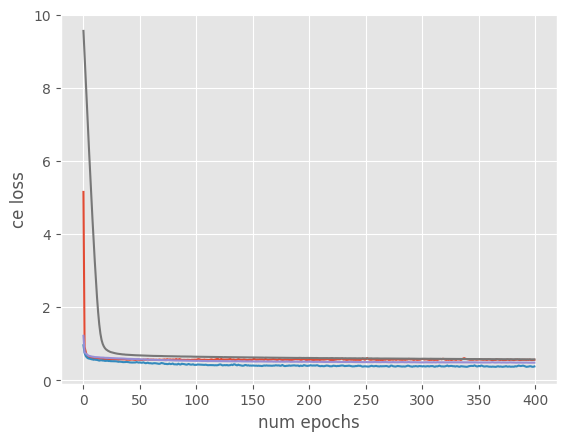

In [28]:
split = None
test_losses = {}
test_accuracies = {}

# hyperparam tuning
max_epoch = 400
lrs = [1e-1, 1e-2, 1e-3, 1e-4] #, 2.5e-4, 1e-4]
batch_sizes = [256]
layer_sizes = [64]

for batch_size in batch_sizes:
    train_dataloader, test_dataloader = get_dataloaders(split, batch_size)
    
    for lr in lrs:
        for layer_size in layer_sizes:
            losses, policy, criterion = train_epochs(train_dataloader, lr, max_epoch, layer_size)
            avg_loss, accuracy = test_policy(test_dataloader, policy, criterion)

            params = f"layer_size={layer_size}_lr={lr}_batch={batch_size}"
            test_losses[params] = avg_loss
            test_accuracies[params] = accuracy
            
            save_plot(losses, lr, batch_size, max_epoch, layer_size)

In [30]:
best_loss = 1e100
best_loss_params = None
best_accuracy = -1
best_accuracy_params = None

for params in test_losses.keys():
    if test_losses[params] < best_loss:
        best_loss = test_losses[params]
        best_loss_params = params
    if test_accuracies[params] > best_accuracy:
        best_accuracy = test_accuracies[params]
        best_accuracy_params = params

print(f'best_loss')
print(f'model: {best_loss_params}')
print(f'loss: {best_loss}')
      
print(f'best_accuracy')
print(f'model: {best_accuracy_params}')
print(f'loss: {best_accuracy}')   

best_loss
model: layer_size=64_lr=0.01_batch=256
loss: 0.37837259131582246
best_accuracy
model: layer_size=64_lr=0.01_batch=256
loss: 0.8692033293697978


TEST [CE LOSS]: 0.38146660978149666
TEST [ACCURACY]: 0.8660325009908839


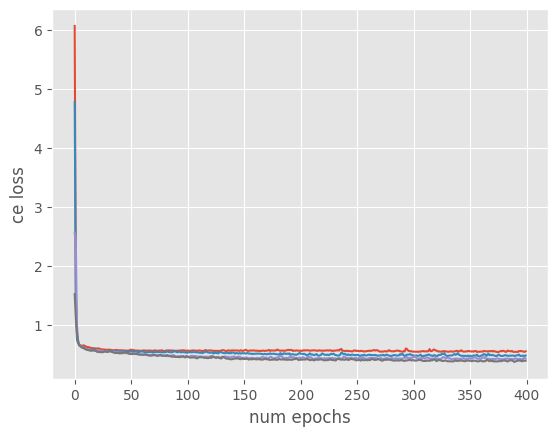

In [31]:
# hyperparam tuning
max_epoch = 400
lrs = [7e-2, 5e-2, 3e-2, 1e-2]
batch_sizes = [256]
layer_sizes = [64]

for batch_size in batch_sizes:
    train_dataloader, test_dataloader = get_dataloaders(split, batch_size)
    
    for lr in lrs:
        for layer_size in layer_sizes:
            losses, policy, criterion = train_epochs(train_dataloader, lr, max_epoch, layer_size)
            avg_loss, accuracy = test_policy(test_dataloader, policy, criterion)

            params = f"layer_size={layer_size}_lr={lr}_batch={batch_size}"
            test_losses[params] = avg_loss
            test_accuracies[params] = accuracy
            
            save_plot(losses, lr, batch_size, max_epoch, layer_size)            

In [33]:
best_loss = 1e100
best_loss_params = None
best_accuracy = -1
best_accuracy_params = None

for params in test_losses.keys():
    if test_losses[params] < best_loss:
        best_loss = test_losses[params]
        best_loss_params = params
    if test_accuracies[params] > best_accuracy:
        best_accuracy = test_accuracies[params]
        best_accuracy_params = params

print(f'best_loss')
print(f'model: {best_loss_params}')
print(f'loss: {best_loss}')
      
print(f'best_accuracy')
print(f'model: {best_accuracy_params}')
print(f'loss: {best_accuracy}')   

best_loss
model: layer_size=64_lr=0.01_batch=256
loss: 0.38146660978149666
best_accuracy
model: layer_size=64_lr=0.03_batch=256
loss: 0.8676179151803408
